# `AVDOS-VR` - Virtual Reality Affective Video Database with Physiological Signals

Check `2_affect...ipynb` to see details of the affect classification

This notebook runs the classification models using the file below, which is the feature-based dataset:
- Feature based: `/temp/2_affect/Dataset_AVDOS_ManualFeaturesWithAnnotations.csv`

In [1]:
# Add files to sys.path
from pathlib import Path
import sys,os
this_path = None
try:    # WORKS WITH .py
    this_path = str(os.path.dirname(os.path.abspath(__file__)))+"/" 
except: # WORKS WITH .ipynb
    this_path = str(Path().absolute())+"/" 
print("File Path:", this_path)

# Add the level up to the file path so it recognizes the scripts inside `avdosvr`
sys.path.append(os.path.join(this_path, ".."))

File Path: e:\dsv\dev\git_repos\AVDOS-VR\notebooks/


In [2]:
# Import classes
import avdosvr.preprocessing       # Generate dataset index, load files, and plots.

# Utils for generation of files and paths
from avdosvr.utils import files_handler

# Import data science libs
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
#matplotlib.rcParams['text.usetex'] = True
import seaborn as sns

# Statistical tests
import scipy.stats as stats
from scipy.stats import mannwhitneyu, f_oneway

# Preprocessing
import neurokit2 as nk

from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Feature based classification

from sklearn.base import clone
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso, RidgeClassifier
from sklearn.svm import LinearSVC, SVC

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Feature selection
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# from lime import lime_tabular

# Evaluation
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Turn off chained assignment warning
pd.options.mode.chained_assignment = None 



#### DURING CROSS-VAL WHEN PRECISION=0
from sklearn.exceptions import UndefinedMetricWarning
import warnings
warnings.filterwarnings('ignore', category=UndefinedMetricWarning) 

---
## Setup

Global variables and functions for file management

In [3]:
### General configuration

# Path to the participants' folder w.r.t this notebook's filepath
DATASET_ROOT_FOLDER = "../data/"

# Used to generate the path of temporary subfolders
NOTEBOOK_NAME = "3_ml"

In [4]:
# Functions to generate filepaths

# MAIN FOLDERS FOR OUTPUT FILES
ROOT = this_path + ""   # Root folder for all the files w.r.t this file
TEMP_FOLDER = ROOT+"temp/"  # Main folder for temp files with intermediate calculations
RESULTS_FOLDER = ROOT+"results/"    # Folder to recreate plots and results from analyses

EXPORT_PLOTS = True
IMG_FORMAT = ".pdf"

# Generates paths for files created from this script

def gen_path_plot(filename, extension=IMG_FORMAT):
    # Generates full paths for PLOTS just by specifying a name
    return files_handler.generate_complete_path(filename, \
                                        main_folder=RESULTS_FOLDER, \
                                        subfolders=NOTEBOOK_NAME+"/plots/", \
                                        file_extension=extension, save_files=EXPORT_PLOTS)

def gen_path_temp(filename, extension, subfolders=""):
    # Generates full paths for TEMP FILES just by specifying a name
    return files_handler.generate_complete_path(filename, \
                                        main_folder=TEMP_FOLDER, \
                                        subfolders=NOTEBOOK_NAME+"/"+subfolders, \
                                        file_extension=extension)

def gen_path_results(filename, subfolders="", extension=""):
    # Generates full paths for RESULTS FILES (like pandas dataframes)
    return files_handler.generate_complete_path(filename, \
                                        main_folder=RESULTS_FOLDER, \
                                        subfolders=NOTEBOOK_NAME+"/"+subfolders, \
                                        file_extension=extension)

---
## Analysis 3: Valence and Arousal Classification from Physiological Signals

- Select subset of features: `[Cardiac, Motor, Facial]`
- Configure the train-test strategy for CV with [Leave-One-Subject-Out (LOSO)](https://scikit-learn.org/stable/modules/cross_validation.html#leave-one-group-out)

### Load dataset with extracted features

In [5]:
FEATURE_BASED_DATASET_FILENAME = TEMP_FOLDER + "2_affect/Dataset_AVDOS_ManualFeaturesWithAnnotations.csv"

df_feature_extraction = None

if (os.path.isfile(FEATURE_BASED_DATASET_FILENAME)):
    df_feature_extraction = pd.read_csv(FEATURE_BASED_DATASET_FILENAME)
    print(f"File loaded from path!")
else:
    print(f"Generate this file from NOTEBOOK 2!")

File loaded from path!


In [6]:
# Identify samples with insufficient HR quality
low_quality_samples = df_feature_extraction[df_feature_extraction['Mean_BPM']==-1]
low_quality_samples["segment"].value_counts()

Positive            216
Negative            205
Neutral             145
Resting_Neutral      66
Resting_Positive     60
Resting_Negative     49
Name: segment, dtype: int64

In [7]:
# Drop low quality samples
df_feature_extraction = df_feature_extraction.drop(low_quality_samples.index,axis=0).reset_index(drop=True)
df_feature_extraction

,participant,segment,i_window,w_center,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_SDSD,HRV_MedianNN,HRV_IQRNN,...,Emg/Amplitude[LeftOrbicularis]_rms,Emg/Amplitude[LeftZygomaticus]_rms,Emg/Amplitude[LeftFrontalis]_rms,Emg/Contact[RightFrontalis]_rms,Emg/Contact[RightZygomaticus]_rms,Emg/Contact[RightOrbicularis]_rms,Emg/Contact[CenterCorrugator]_rms,Emg/Contact[LeftOrbicularis]_rms,Emg/Contact[LeftZygomaticus]_rms,Emg/Contact[LeftFrontalis]_rms
0,0,Positive,0,15.0,798.918919,31.603778,26.246693,26.619005,800.0,40.0,...,0.317241,0.182433,0.251687,0.069182,0.041723,0.082977,0.026165,0.274487,0.040265,0.225888
1,0,Positive,1,25.0,790.000000,33.295216,36.095112,36.622076,780.0,45.0,...,0.916304,1.193573,0.265152,0.064417,0.046350,0.091420,0.026363,0.280247,0.040666,0.229746
2,0,Positive,2,35.0,803.888889,39.372055,34.475664,34.978985,800.0,60.0,...,0.985619,1.237416,0.291602,0.069145,0.046034,0.092095,0.027075,0.277878,0.040319,0.217557
3,0,Positive,3,45.0,818.857143,39.390311,29.505732,29.949452,820.0,50.0,...,1.040706,1.283823,0.302112,0.074791,0.044807,0.089444,0.027220,0.273889,0.038709,0.200540
4,0,Positive,4,55.0,821.714286,33.385953,27.224556,27.575856,820.0,40.0,...,0.598250,0.545370,0.308870,0.080046,0.037611,0.081635,0.027019,0.259340,0.038289,0.173470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3248,36,Resting_Neutral,5,65.0,636.888889,63.811591,27.136021,27.260392,640.0,120.0,...,0.365013,0.325065,0.293128,0.362692,0.069362,0.076541,0.104749,0.053566,0.153578,0.389521
3249,36,Resting_Neutral,6,75.0,623.404255,49.399727,25.707383,25.991452,620.0,80.0,...,0.382025,0.372778,0.328671,0.360605,0.066353,0.096947,0.142616,0.034389,0.149104,0.420186
3250,36,Resting_Neutral,7,85.0,628.695652,58.825871,31.832897,32.180049,620.0,80.0,...,0.402186,0.427228,0.330542,0.322920,0.054520,0.159995,0.291727,0.096605,0.139303,0.443406
3251,36,Resting_Neutral,8,95.0,673.488372,50.279397,34.778209,35.170070,660.0,60.0,...,0.422391,0.468328,0.345033,0.337629,0.039222,0.208373,0.391464,0.136079,0.129702,0.472452


In [8]:
## TARGET FOR CLASSIFICATION
TARGET_AFFECT_DIMENSION = "VALENCE" #  "VALENCE" or "AROUSAL"

CLASSES_MAPPING = {
                    ## 3-CLASS VALENCE
                    "VALENCE": {
                                "Negative": -1,
                                "Neutral": 0,
                                "Positive": 1,
                                },

                    # BINARY AROUSAL: Both Negative and Positive present HIGH arousing videos
                    "AROUSAL":{
                                "Neutral": 0,
                                "Negative": 1,
                                "Positive": 1,
                                }
                }

In [9]:
df_feature_extraction

,participant,segment,i_window,w_center,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_SDSD,HRV_MedianNN,HRV_IQRNN,...,Emg/Amplitude[LeftOrbicularis]_rms,Emg/Amplitude[LeftZygomaticus]_rms,Emg/Amplitude[LeftFrontalis]_rms,Emg/Contact[RightFrontalis]_rms,Emg/Contact[RightZygomaticus]_rms,Emg/Contact[RightOrbicularis]_rms,Emg/Contact[CenterCorrugator]_rms,Emg/Contact[LeftOrbicularis]_rms,Emg/Contact[LeftZygomaticus]_rms,Emg/Contact[LeftFrontalis]_rms
0,0,Positive,0,15.0,798.918919,31.603778,26.246693,26.619005,800.0,40.0,...,0.317241,0.182433,0.251687,0.069182,0.041723,0.082977,0.026165,0.274487,0.040265,0.225888
1,0,Positive,1,25.0,790.000000,33.295216,36.095112,36.622076,780.0,45.0,...,0.916304,1.193573,0.265152,0.064417,0.046350,0.091420,0.026363,0.280247,0.040666,0.229746
2,0,Positive,2,35.0,803.888889,39.372055,34.475664,34.978985,800.0,60.0,...,0.985619,1.237416,0.291602,0.069145,0.046034,0.092095,0.027075,0.277878,0.040319,0.217557
3,0,Positive,3,45.0,818.857143,39.390311,29.505732,29.949452,820.0,50.0,...,1.040706,1.283823,0.302112,0.074791,0.044807,0.089444,0.027220,0.273889,0.038709,0.200540
4,0,Positive,4,55.0,821.714286,33.385953,27.224556,27.575856,820.0,40.0,...,0.598250,0.545370,0.308870,0.080046,0.037611,0.081635,0.027019,0.259340,0.038289,0.173470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3248,36,Resting_Neutral,5,65.0,636.888889,63.811591,27.136021,27.260392,640.0,120.0,...,0.365013,0.325065,0.293128,0.362692,0.069362,0.076541,0.104749,0.053566,0.153578,0.389521
3249,36,Resting_Neutral,6,75.0,623.404255,49.399727,25.707383,25.991452,620.0,80.0,...,0.382025,0.372778,0.328671,0.360605,0.066353,0.096947,0.142616,0.034389,0.149104,0.420186
3250,36,Resting_Neutral,7,85.0,628.695652,58.825871,31.832897,32.180049,620.0,80.0,...,0.402186,0.427228,0.330542,0.322920,0.054520,0.159995,0.291727,0.096605,0.139303,0.443406
3251,36,Resting_Neutral,8,95.0,673.488372,50.279397,34.778209,35.170070,660.0,60.0,...,0.422391,0.468328,0.345033,0.337629,0.039222,0.208373,0.391464,0.136079,0.129702,0.472452


*Missing values*

In [10]:
df_feature_extraction.isna().sum().sum()

2298

In [11]:
# Missing values are in the calculation of kurtosis and skewness - Impute forward
df_feature_extraction = df_feature_extraction.fillna(method="ffill")
df_feature_extraction.isna().sum().sum()

0

In [12]:
data_X = df_feature_extraction.loc[(df_feature_extraction['segment'] == 'Positive')  | 
                                   (df_feature_extraction['segment'] == 'Negative') | 
                                   (df_feature_extraction['segment'] == 'Neutral')]
data_X = data_X.reset_index(drop=True)
data_X = data_X.drop(["segment"], axis=1)
data_X

,participant,i_window,w_center,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_SDSD,HRV_MedianNN,HRV_IQRNN,Mean_BPM,...,Emg/Amplitude[LeftOrbicularis]_rms,Emg/Amplitude[LeftZygomaticus]_rms,Emg/Amplitude[LeftFrontalis]_rms,Emg/Contact[RightFrontalis]_rms,Emg/Contact[RightZygomaticus]_rms,Emg/Contact[RightOrbicularis]_rms,Emg/Contact[CenterCorrugator]_rms,Emg/Contact[LeftOrbicularis]_rms,Emg/Contact[LeftZygomaticus]_rms,Emg/Contact[LeftFrontalis]_rms
0,0,0,15.0,798.918919,31.603778,26.246693,26.619005,800.0,40.0,75.111431,...,0.317241,0.182433,0.251687,0.069182,0.041723,0.082977,0.026165,0.274487,0.040265,0.225888
1,0,1,25.0,790.000000,33.295216,36.095112,36.622076,780.0,45.0,75.994305,...,0.916304,1.193573,0.265152,0.064417,0.046350,0.091420,0.026363,0.280247,0.040666,0.229746
2,0,2,35.0,803.888889,39.372055,34.475664,34.978985,800.0,60.0,74.657658,...,0.985619,1.237416,0.291602,0.069145,0.046034,0.092095,0.027075,0.277878,0.040319,0.217557
3,0,3,45.0,818.857143,39.390311,29.505732,29.949452,820.0,50.0,73.285738,...,1.040706,1.283823,0.302112,0.074791,0.044807,0.089444,0.027220,0.273889,0.038709,0.200540
4,0,4,55.0,821.714286,33.385953,27.224556,27.575856,820.0,40.0,73.020900,...,0.598250,0.545370,0.308870,0.080046,0.037611,0.081635,0.027019,0.259340,0.038289,0.173470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2405,36,23,245.0,658.181818,63.950298,63.758264,64.497375,660.0,65.0,91.274869,...,0.368170,0.473455,0.385133,0.286967,0.147483,0.139122,0.144198,0.021939,0.169437,0.216797
2406,36,24,255.0,655.909091,62.443209,63.024543,63.726992,650.0,60.0,91.517038,...,0.373835,0.471782,0.439867,0.305590,0.121343,0.141479,0.129871,0.027827,0.136201,0.192870
2407,36,25,265.0,633.913043,51.617321,59.777365,60.426096,640.0,60.0,94.726423,...,0.351267,0.451655,0.427124,0.283192,0.083204,0.139965,0.117047,0.036528,0.089459,0.171461
2408,36,26,275.0,628.260870,48.912818,46.761808,47.281662,620.0,40.0,95.549031,...,0.322619,0.447637,0.406282,0.385744,0.044576,0.184473,0.148816,0.038067,0.024692,0.243458


In [13]:
data_Y = df_feature_extraction.loc[(df_feature_extraction['segment'] == 'Positive')  | 
                                   (df_feature_extraction['segment'] == 'Negative') | 
                                   (df_feature_extraction['segment'] == 'Neutral')]
data_Y = data_Y.reset_index(drop=True)

### MAPPING VIDEO GROUPS TO DIFFERENT CLASS LABELS
data_Y = data_Y["segment"].map(CLASSES_MAPPING[TARGET_AFFECT_DIMENSION])

print(f"Classifying: {TARGET_AFFECT_DIMENSION} with classes: {set(data_Y.values)}")

Classifying: VALENCE with classes: {0, 1, -1}


<AxesSubplot: >

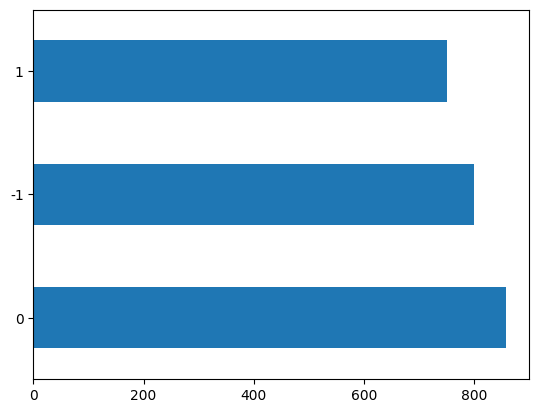

In [14]:
# Valence labels distribution
data_Y.value_counts().plot.barh()

<AxesSubplot: >

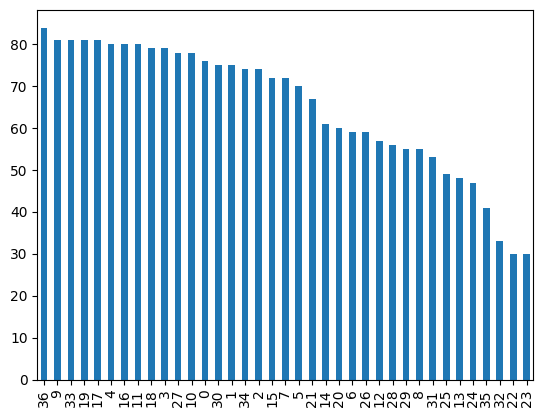

In [15]:
data_participant = df_feature_extraction.loc[(df_feature_extraction['segment'] == 'Positive')  | 
                                   (df_feature_extraction['segment'] == 'Negative') | 
                                   (df_feature_extraction['segment'] == 'Neutral')]
data_participant = data_participant.reset_index(drop=True)
data_participant = data_participant.participant
data_participant.value_counts().plot.bar()

In [16]:
len(list(set(data_participant)))

37

### Feature selection per data modality

In [17]:
colname_prefix = {
    "VALENCE": "Valence",
    "AROUSAL": "Arousal",
}

annotations_colnames = data_X.columns[ [ (col.startswith( colname_prefix[TARGET_AFFECT_DIMENSION] )) for col in data_X.columns] ].sort_values().values
annotations_colnames

array(['Valence_energy', 'Valence_irq', 'Valence_kurt', 'Valence_max',
       'Valence_mean', 'Valence_median', 'Valence_min', 'Valence_pnv',
       'Valence_ppv', 'Valence_rms', 'Valence_skew', 'Valence_std'],
      dtype=object)

In [18]:
hrv_colnames = data_X.columns[ [ (col.startswith("HRV") | col.startswith("HeartRate") | col.startswith("Ppg/")) for col in data_X.columns] ].sort_values().values
hrv_colnames

array(['HRV_IQRNN', 'HRV_MeanNN', 'HRV_MedianNN', 'HRV_RMSSD', 'HRV_SDNN',
       'HRV_SDSD', 'HeartRate/Average_energy', 'HeartRate/Average_irq',
       'HeartRate/Average_kurt', 'HeartRate/Average_max',
       'HeartRate/Average_mean', 'HeartRate/Average_median',
       'HeartRate/Average_min', 'HeartRate/Average_pnv',
       'HeartRate/Average_ppv', 'HeartRate/Average_rms',
       'HeartRate/Average_skew', 'HeartRate/Average_std',
       'Ppg/Raw.ppg_energy', 'Ppg/Raw.ppg_irq', 'Ppg/Raw.ppg_kurt',
       'Ppg/Raw.ppg_max', 'Ppg/Raw.ppg_mean', 'Ppg/Raw.ppg_median',
       'Ppg/Raw.ppg_min', 'Ppg/Raw.ppg_pnv', 'Ppg/Raw.ppg_ppv',
       'Ppg/Raw.ppg_rms', 'Ppg/Raw.ppg_skew', 'Ppg/Raw.ppg_std',
       'Ppg/Raw.proximity_energy', 'Ppg/Raw.proximity_irq',
       'Ppg/Raw.proximity_kurt', 'Ppg/Raw.proximity_max',
       'Ppg/Raw.proximity_mean', 'Ppg/Raw.proximity_median',
       'Ppg/Raw.proximity_min', 'Ppg/Raw.proximity_pnv',
       'Ppg/Raw.proximity_ppv', 'Ppg/Raw.proximity_rms',
    

In [19]:
imu_colnames = data_X.columns[ [ (col.startswith("Accelerometer")) | (col.startswith("Magnetometer")) | (col.startswith("Gyroscope")) for col in data_X.columns] ].sort_values().values
imu_colnames

array(['Accelerometer/Raw.x_energy', 'Accelerometer/Raw.x_irq',
       'Accelerometer/Raw.x_kurt', 'Accelerometer/Raw.x_max',
       'Accelerometer/Raw.x_mean', 'Accelerometer/Raw.x_median',
       'Accelerometer/Raw.x_min', 'Accelerometer/Raw.x_pnv',
       'Accelerometer/Raw.x_ppv', 'Accelerometer/Raw.x_rms',
       'Accelerometer/Raw.x_skew', 'Accelerometer/Raw.x_std',
       'Accelerometer/Raw.y_energy', 'Accelerometer/Raw.y_irq',
       'Accelerometer/Raw.y_kurt', 'Accelerometer/Raw.y_max',
       'Accelerometer/Raw.y_mean', 'Accelerometer/Raw.y_median',
       'Accelerometer/Raw.y_min', 'Accelerometer/Raw.y_pnv',
       'Accelerometer/Raw.y_ppv', 'Accelerometer/Raw.y_rms',
       'Accelerometer/Raw.y_skew', 'Accelerometer/Raw.y_std',
       'Accelerometer/Raw.z_energy', 'Accelerometer/Raw.z_irq',
       'Accelerometer/Raw.z_kurt', 'Accelerometer/Raw.z_max',
       'Accelerometer/Raw.z_mean', 'Accelerometer/Raw.z_median',
       'Accelerometer/Raw.z_min', 'Accelerometer/Raw.z_pnv'

In [20]:
emg_amp_colnames = data_X.columns[ [ (col.startswith("Emg/Amplitude")) for col in data_X.columns] ].sort_values().values
emg_amp_colnames

array(['Emg/Amplitude[CenterCorrugator]_energy',
       'Emg/Amplitude[CenterCorrugator]_irq',
       'Emg/Amplitude[CenterCorrugator]_kurt',
       'Emg/Amplitude[CenterCorrugator]_max',
       'Emg/Amplitude[CenterCorrugator]_mean',
       'Emg/Amplitude[CenterCorrugator]_median',
       'Emg/Amplitude[CenterCorrugator]_min',
       'Emg/Amplitude[CenterCorrugator]_pnv',
       'Emg/Amplitude[CenterCorrugator]_ppv',
       'Emg/Amplitude[CenterCorrugator]_rms',
       'Emg/Amplitude[CenterCorrugator]_skew',
       'Emg/Amplitude[CenterCorrugator]_std',
       'Emg/Amplitude[LeftFrontalis]_energy',
       'Emg/Amplitude[LeftFrontalis]_irq',
       'Emg/Amplitude[LeftFrontalis]_kurt',
       'Emg/Amplitude[LeftFrontalis]_max',
       'Emg/Amplitude[LeftFrontalis]_mean',
       'Emg/Amplitude[LeftFrontalis]_median',
       'Emg/Amplitude[LeftFrontalis]_min',
       'Emg/Amplitude[LeftFrontalis]_pnv',
       'Emg/Amplitude[LeftFrontalis]_ppv',
       'Emg/Amplitude[LeftFrontalis]_rms',
 

In [21]:
emg_cont_colnames = data_X.columns[ [ (col.startswith("Emg/Contact")) for col in data_X.columns] ].sort_values().values
emg_cont_colnames

array(['Emg/Contact[CenterCorrugator]_energy',
       'Emg/Contact[CenterCorrugator]_irq',
       'Emg/Contact[CenterCorrugator]_kurt',
       'Emg/Contact[CenterCorrugator]_max',
       'Emg/Contact[CenterCorrugator]_mean',
       'Emg/Contact[CenterCorrugator]_median',
       'Emg/Contact[CenterCorrugator]_min',
       'Emg/Contact[CenterCorrugator]_pnv',
       'Emg/Contact[CenterCorrugator]_ppv',
       'Emg/Contact[CenterCorrugator]_rms',
       'Emg/Contact[CenterCorrugator]_skew',
       'Emg/Contact[CenterCorrugator]_std',
       'Emg/Contact[LeftFrontalis]_energy',
       'Emg/Contact[LeftFrontalis]_irq',
       'Emg/Contact[LeftFrontalis]_kurt',
       'Emg/Contact[LeftFrontalis]_max',
       'Emg/Contact[LeftFrontalis]_mean',
       'Emg/Contact[LeftFrontalis]_median',
       'Emg/Contact[LeftFrontalis]_min', 'Emg/Contact[LeftFrontalis]_pnv',
       'Emg/Contact[LeftFrontalis]_ppv', 'Emg/Contact[LeftFrontalis]_rms',
       'Emg/Contact[LeftFrontalis]_skew',
       'Emg/Conta

In [22]:
print(f"Annotations: {annotations_colnames.size}")
print(f"HRV {hrv_colnames.size}")
print(f"IMU {imu_colnames.size}")
print(f"EMG Amplitude {emg_amp_colnames.size}")
print(f"EMG Contact {emg_cont_colnames.size}")

Annotations: 12
HRV 42
IMU 108
EMG Amplitude 84
EMG Contact 84


### Classification models

Important reading: [Common pitfalls in the interpretation of coeffs in linear models.](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#sphx-glr-auto-examples-inspection-plot-linear-model-coefficient-interpretation-py)

In [23]:
# FEATURE-BASED CLASSIFIERS CLASSIFIERS SETUP
MC_RANDOM_SEED = 1234
N_SPLITS_CV = 10 # Number of folds for Cross-validation

# Scoring parameters: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
SCORING_METRICS = ["accuracy", "f1_macro", "precision_macro", "recall_macro"]

*Testing Classification pipeline*

In [24]:
## Example of iterator for Cross-validation per subject

# Feature subset
feature_subset_colnames = hrv_colnames   # imu_colnames, emg_amp_colnames, emg_cont_colnames

# Features
x = data_X[feature_subset_colnames]
y = data_Y

# Groups indices (participants' ids)
group_cv = data_participant

loso_cv = LeaveOneGroupOut()
cv_splits = loso_cv.split(x, y, groups=group_cv)
for trn_idx, tst_idx in cv_splits:
    print("TRN: %s \t TST: %s" % (data_participant[trn_idx].unique(), data_participant[tst_idx].unique()))

TRN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36] 	 TST: [0]
TRN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36] 	 TST: [1]
TRN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36] 	 TST: [2]
TRN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36] 	 TST: [3]
TRN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36] 	 TST: [4]
TRN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36] 	 TST: [5]
TRN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36] 	 TST: [6]
TRN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35

In [25]:
# Deep learner Keras CLassifier

from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

from tensorflow import keras
def get_clf(meta, hidden_layer_sizes, dropout):
    n_features_in_ = meta["n_features_in_"]
    n_classes_ = meta["n_classes_"]
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(n_features_in_,)))
    for hidden_layer_size in hidden_layer_sizes:
        model.add(keras.layers.Dense(hidden_layer_size, activation="relu"))
        model.add(keras.layers.Dropout(dropout))
    # model.add(keras.layers.Dense( 3 , activation="sigmoid")) # For 3-class valence

    ### LQ: Changing the output layer based on the classification task
    output_dimension = 3 if TARGET_AFFECT_DIMENSION=="VALENCE" else 1

    model.add(keras.layers.Dense( output_dimension , activation="sigmoid"))
    return model

clf = KerasClassifier(
    model=get_clf,
    loss="CategoricalCrossentropy",
    optimizer="adam",
    optimizer__learning_rate=0.1,
    model__hidden_layer_sizes=(100,),
    model__dropout=0.5,
    verbose=False,
)

### Apply classification task

In [26]:
data_modality_colnames = {
            "annotations": annotations_colnames,
            "hrv": hrv_colnames, 
            "imu": imu_colnames, 
            "emg_amp": emg_amp_colnames,
            "emg_cont": emg_cont_colnames,
            "all": list(hrv_colnames) + list(imu_colnames) + list(emg_amp_colnames) + list(emg_cont_colnames),
    }

# ClassifierName: {"clf":model, "pgrid":parameters)
classifiers_hyperparams = {
    "LinearRidge": {    "clf": RidgeClassifier(alpha=0.01, max_iter=1000), # n_class classifiers are trained in a one-versus-all approach. Concretely, taking advantage of the multi-variate response support in Ridge
                        "pgrid": {'alpha': np.logspace(-5, 5,11) }},
    "GaussianSVM": {    "clf": SVC(kernel='rbf', gamma='auto', C = 1),          # Multilabel in one-vs-one approach
                        "pgrid": {'C': [1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001]}},
    "RF": {             "clf": RandomForestClassifier(criterion='entropy', random_state=MC_RANDOM_SEED, class_weight="balanced"), # Multilabel classification
                        "pgrid": {'n_estimators': [10, 50, 100], 'max_depth': [5, 10, 20]}},
    "KNN": {            "clf": KNeighborsClassifier(),
                        "pgrid": {'n_neighbors': [1, 5, 11, 15]}},
    "DL": {
            "clf": KerasClassifier(
                model=get_clf,
                loss="categorical_crossentropy",
                optimizer="adam",
                optimizer__learning_rate=0.1,
                model__hidden_layer_sizes=(100,),
                model__dropout=0.5,
                verbose=False,
            ),
            "pgrid": {
                'optimizer__learning_rate': [0.05, 0.001],
                'model__hidden_layer_sizes': [(100, ), (50, 50, )],
                'model__dropout': [0, 0.5],
            },
    },

    }

The execution below takes around 6 hours for 37 people on a 6-core Intel i7-8750H

In [27]:
# Loading all segments for all participants and store the resting and video parts in a single large CSV.

## TARGET SUFFIX

DATASET_POSTPROCESSED_FILENAME = gen_path_temp("Results_ModelTrainingCV_PerDataModalityPerSubject_37p_"+TARGET_AFFECT_DIMENSION, extension=".csv")

output_filename = DATASET_POSTPROCESSED_FILENAME

# Variable to store the final dataset
df_results_hyperparam_opt = None

# Check if file already exists
if (os.path.isfile(output_filename)):
    df_results_hyperparam_opt = pd.read_csv(output_filename)
    print(f"File loaded from path!")
# Otherwise generate it
else:
    print(f"Generating file!")
    
    ## Iteration per data type
    for modality_name, modality_colnames in data_modality_colnames.items(): 

        # modality_name = "hrv"
        # modality_colnames = data_modality_colnames[modality_name]
        #### ABOVE FOR TESTING

        # Subset of features
        data_mod_x = data_X[modality_colnames].values.copy()   # Features
        data_mod_y = data_Y.values.copy()

        subject_ids = data_participant.values.copy()  # Groups indices (participants' ids)

        # Split dataset with LOSO-CV
        cv_loso_subj = LeaveOneGroupOut()
        cv_splits_subjects = cv_loso_subj.split(data_mod_x, data_mod_y, groups=subject_ids)

        # Iteration per subject (participant)
        for trn_subj_idx, tst_subj_idx in cv_splits_subjects:

            # The dataset that is not belonging to the TEST subject will be further divided for hyperparam optimization.
            x = data_mod_x[trn_subj_idx]             # Data to be used to create a model for TEST subject
            x_test_subj = data_mod_x[tst_subj_idx]
            y = data_mod_y[trn_subj_idx]
            y_test_subj = data_mod_y[tst_subj_idx]
            subjects_cv = data_participant[trn_subj_idx].values
            subject_in_test_set = np.unique(data_participant[tst_subj_idx].values)[0]   # Store the participant id in the test set
            
            # print(f"TRAIN SUBJECT IDS: {np.unique(subjects_cv)} \t TEST SUBJECT: {subject_in_test_set}")
            # print(f"SHAPE : x:{x.shape}, x_test_subj:{x_test_subj.shape}, y:{y.shape}, y_test_subj:{y_test_subj.shape}, subjects_cv:{subjects_cv.shape}")

            # Create pipeline
            scaler = StandardScaler().fit(x)
            x_scaled = scaler.transform(x)

            for clf_name, clf_data in classifiers_hyperparams.items(): 
                # clf_name = "GaussianSVM"
                # clf_data = classifiers_hyperparams[clf_name]
                #### ABOVE FOR TESTING

                clf = clf_data["clf"]
                pgrid = clf_data["pgrid"]
                                
                # Leave-One-Subject-Out CV also to optimize the hyperparameters and select a model
                cv_loso_fold = LeaveOneGroupOut()
                cv_fold_per_subject = cv_loso_subj.split(x, y, groups = subjects_cv)

                gr_search = GridSearchCV(clf, pgrid, cv=cv_fold_per_subject, scoring=SCORING_METRICS, refit="accuracy", n_jobs=1)
                gr_search.fit(x_scaled, y)

                # Get results per fold and add best results
                df_this_hyperparam_optim = pd.DataFrame(gr_search.cv_results_)
                df_this_hyperparam_optim.insert(0,"best_trn_score_", str(gr_search.best_score_))
                df_this_hyperparam_optim.insert(0,"best_params_", str(gr_search.best_params_))
                df_this_hyperparam_optim.insert(0,"best_estimator_", str(gr_search.best_estimator_))

                # Insert general information in long format
                df_this_hyperparam_optim.insert(0,"classifier", clf_name)
                df_this_hyperparam_optim.insert(0, "test_subject_id",subject_in_test_set)
                df_this_hyperparam_optim.insert(0, "data_modality", modality_name)
                df_this_hyperparam_optim.insert(0, "pipeline_step", "hyperparam_opt")

                # Append to the main dataframe with the results 
                df_results_hyperparam_opt = df_this_hyperparam_optim if (df_results_hyperparam_opt is None) else pd.concat([df_results_hyperparam_opt, df_this_hyperparam_optim], axis=0, ignore_index=True)
                
                print(f"Data modality: {modality_name} | Clf: {clf_name} | Subject: {subject_in_test_set} ")

                # Saving .csv
                df_results_hyperparam_opt.to_csv( output_filename, index=False)

            # End of classifiers
        # End of subjects

        # # Saving .csv every iteration
        # df_results_hyperparam_opt.to_csv( output_filename )
    print("\n\n End")

File loaded from path!


C:\Users\luva3178\AppData\Local\Temp\ipykernel_8144\3218329515.py:14: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_results_hyperparam_opt = pd.read_csv(output_filename)


In [28]:
df_results_hyperparam_opt.sample(5)

,pipeline_step,data_modality,test_subject_id,classifier,best_estimator_,best_params_,best_trn_score_,mean_fit_time,std_fit_time,mean_score_time,...,split34_test_recall_macro,split35_test_recall_macro,mean_test_recall_macro,std_test_recall_macro,rank_test_recall_macro,param_C,param_gamma,param_max_depth,param_n_estimators,param_n_neighbors
9729,hyperparam_opt,all,32,DL,KerasClassifier(\n\tmodel=<function get_clf at...,"{'model__dropout': 0, 'model__hidden_layer_siz...",0.743733,1.180227,0.131855,0.125657,...,0.964286,0.571429,0.719907,0.964286,0.752135,0.195240,1.0,NaN,NaN,NaN
1479,hyperparam_opt,annotations,18,DL,KerasClassifier(\n\tmodel=<function get_clf at...,"{'model__dropout': 0, 'model__hidden_layer_siz...",0.787388,1.550829,0.173007,0.163154,...,0.717619,0.905873,1.000000,0.797619,0.768632,0.163438,3.0,NaN,NaN,NaN
7034,hyperparam_opt,all,2,LinearRidge,"RidgeClassifier(alpha=10000.0, max_iter=1000)",{'alpha': 10000.0},0.762979,0.058992,0.020307,0.008489,...,0.821759,1.000000,0.708821,0.180019,5.000000,NaN,NaN,NaN,NaN,NaN
797,hyperparam_opt,annotations,22,LinearRidge,"RidgeClassifier(alpha=100.0, max_iter=1000)",{'alpha': 100.0},0.789464,0.003970,0.002208,0.010103,...,1.000000,0.833333,0.785214,0.168910,3.000000,NaN,NaN,NaN,NaN,NaN
3644,hyperparam_opt,imu,19,LinearRidge,"RidgeClassifier(alpha=100.0, max_iter=1000)",{'alpha': 100.0},0.497856,0.019415,0.008414,0.008764,...,0.730159,0.571429,0.497997,0.160564,5.000000,NaN,NaN,NaN,NaN,NaN


In [29]:
# Iterate over participants to know the best model per subject and its hyperparams.
for participant in df_results_hyperparam_opt.test_subject_id.unique():
    # participant = 0
    # for clf_name, clf_data in classifiers_hyperparams.items():
    query = ((df_results_hyperparam_opt.test_subject_id == participant) & \
                # (df_results_hyperparam_opt.rank_test_accuracy == 1) & \
                # (df_results_hyperparam_opt.classifier == clf_name) & \
                    (df_results_hyperparam_opt.data_modality == "all") )
    best_results_participant = df_results_hyperparam_opt[ query ]
    best_classifier_gridsearch = best_results_participant[ best_results_participant.mean_test_accuracy == best_results_participant.mean_test_accuracy.max() ]
    best_clf_name = best_classifier_gridsearch.classifier
    
    # Apply the classification on the test subject
    print(f"P{participant} - Best clf: {best_clf_name}\n\tBest performance {best_classifier_gridsearch.mean_test_accuracy.values}\n\tBest params {best_classifier_gridsearch.params.values}")
        

P0 - Best clf: 6981    RF
Name: classifier, dtype: object
	Best performance [0.7800032]
	Best params ["{'max_depth': 5, 'n_estimators': 100}"]
P1 - Best clf: 7017    RF
Name: classifier, dtype: object
	Best performance [0.78207845]
	Best params ["{'max_depth': 5, 'n_estimators': 100}"]
P2 - Best clf: 7053    RF
Name: classifier, dtype: object
	Best performance [0.77884435]
	Best params ["{'max_depth': 5, 'n_estimators': 100}"]
P3 - Best clf: 7089    RF
Name: classifier, dtype: object
	Best performance [0.77104544]
	Best params ["{'max_depth': 5, 'n_estimators': 100}"]
P4 - Best clf: 7125    RF
Name: classifier, dtype: object
	Best performance [0.77968798]
	Best params ["{'max_depth': 5, 'n_estimators': 100}"]
P5 - Best clf: 7167    RF
Name: classifier, dtype: object
	Best performance [0.77615454]
	Best params ["{'max_depth': 20, 'n_estimators': 100}"]
P6 - Best clf: 7197    RF
Name: classifier, dtype: object
	Best performance [0.7827486]
	Best params ["{'max_depth': 5, 'n_estimators': 

# RESULTS FROM ML CLASSIFICATION

These results can only be executed when the classification process above has been performed for both `VALENCE` and `AROUSAL` changing the variable `TARGET_AFFECT_DIMENSION`.
The plots assume that both files are already present in the path:
- `notebooks\temp\3_ml\Results_ModelTrainingCV_PerDataModalityPerSubject_37p_AROUSAL.csv`
- `notebooks\temp\3_ml\Results_ModelTrainingCV_PerDataModalityPerSubject_37p_VALENCE.csv`

In [30]:
TARGET_AFFECT_DIMENSION = "VALENCE"
output_filename = gen_path_temp("Results_ModelTrainingCV_PerDataModalityPerSubject_37p_"+TARGET_AFFECT_DIMENSION, extension=".csv")
df_results_valence = pd.read_csv(output_filename)

TARGET_AFFECT_DIMENSION = "AROUSAL"
output_filename = gen_path_temp("Results_ModelTrainingCV_PerDataModalityPerSubject_37p_"+TARGET_AFFECT_DIMENSION, extension=".csv")
df_results_arousal = pd.read_csv(output_filename)


C:\Users\luva3178\AppData\Local\Temp\ipykernel_8144\1761957940.py:3: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_results_valence = pd.read_csv(output_filename)
C:\Users\luva3178\AppData\Local\Temp\ipykernel_8144\1761957940.py:7: DtypeWarning: Columns (12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_results_arousal = pd.read_csv(output_filename)


In [31]:
df_results_arousal

,pipeline_step,data_modality,test_subject_id,classifier,best_estimator_,best_params_,best_trn_score_,mean_fit_time,std_fit_time,mean_score_time,...,split35_test_recall_macro,mean_test_recall_macro,std_test_recall_macro,rank_test_recall_macro,Unnamed: 171,Unnamed: 172,Unnamed: 173,Unnamed: 174,Unnamed: 175,Unnamed: 176
0,hyperparam_opt,annotations,0,LinearRidge,"RidgeClassifier(alpha=10.0, max_iter=1000)",{'alpha': 10.0},0.803604,0.013067,0.003415,0.006799,...,0.77250,0.785714,0.768142,0.138048,4.0,NaN,NaN,NaN,NaN,NaN
1,hyperparam_opt,annotations,0,LinearRidge,"RidgeClassifier(alpha=10.0, max_iter=1000)",{'alpha': 10.0},0.803604,0.013308,0.001880,0.007215,...,0.77250,0.785714,0.768142,0.138048,4.0,NaN,NaN,NaN,NaN,NaN
2,hyperparam_opt,annotations,0,LinearRidge,"RidgeClassifier(alpha=10.0, max_iter=1000)",{'alpha': 10.0},0.803604,0.015090,0.003591,0.006788,...,0.77250,0.785714,0.768142,0.138048,4.0,NaN,NaN,NaN,NaN,NaN
3,hyperparam_opt,annotations,0,LinearRidge,"RidgeClassifier(alpha=10.0, max_iter=1000)",{'alpha': 10.0},0.803604,0.014211,0.003068,0.007002,...,0.77250,0.785714,0.768142,0.138048,4.0,NaN,NaN,NaN,NaN,NaN
4,hyperparam_opt,annotations,0,LinearRidge,"RidgeClassifier(alpha=10.0, max_iter=1000)",{'alpha': 10.0},0.803604,0.013693,0.002155,0.006743,...,0.77250,0.785714,0.770747,0.137681,3.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9763,hyperparam_opt,all,36,DL,KerasClassifier(\n\tmodel=<function get_clf at...,"{'model__dropout': 0.5, 'model__hidden_layer_s...",0.780391,1.598198,0.037777,0.160644,...,0.55375,0.747848,0.181634,2.000000,NaN,NaN,NaN,NaN,NaN,NaN
9764,hyperparam_opt,all,36,DL,KerasClassifier(\n\tmodel=<function get_clf at...,"{'model__dropout': 0.5, 'model__hidden_layer_s...",0.780391,1.313372,0.151988,0.166931,...,0.45375,0.701085,0.159936,6.000000,NaN,NaN,NaN,NaN,NaN,NaN
9765,hyperparam_opt,all,36,DL,KerasClassifier(\n\tmodel=<function get_clf at...,"{'model__dropout': 0.5, 'model__hidden_layer_s...",0.780391,1.308877,0.181961,0.127348,...,0.52250,0.768327,0.181695,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
9766,hyperparam_opt,all,36,DL,KerasClassifier(\n\tmodel=<function get_clf at...,"{'model__dropout': 0.5, 'model__hidden_layer_s...",0.780391,1.723076,0.231114,0.137892,...,0.68000,0.665944,0.146226,8.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# Merge both datasets with the corresponding target
df_results_valence["Target"] = "Valence" #(3-classes)
df_results_arousal["Target"] = "Arousal" #(2-classes)
df_results_complete = pd.concat([df_results_valence, df_results_arousal], axis=0, ignore_index=True)
df_results_complete

,pipeline_step,data_modality,test_subject_id,classifier,best_estimator_,best_params_,best_trn_score_,mean_fit_time,std_fit_time,mean_score_time,...,Target,param_model__dropout,param_model__hidden_layer_sizes,param_optimizer__learning_rate,Unnamed: 171,Unnamed: 172,Unnamed: 173,Unnamed: 174,Unnamed: 175,Unnamed: 176
0,hyperparam_opt,annotations,0,LinearRidge,"RidgeClassifier(alpha=10.0, max_iter=1000)",{'alpha': 10.0},0.781778,0.003257,0.000463,0.006650,...,Valence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,hyperparam_opt,annotations,0,LinearRidge,"RidgeClassifier(alpha=10.0, max_iter=1000)",{'alpha': 10.0},0.781778,0.002794,0.000548,0.006097,...,Valence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,hyperparam_opt,annotations,0,LinearRidge,"RidgeClassifier(alpha=10.0, max_iter=1000)",{'alpha': 10.0},0.781778,0.002656,0.000499,0.005816,...,Valence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,hyperparam_opt,annotations,0,LinearRidge,"RidgeClassifier(alpha=10.0, max_iter=1000)",{'alpha': 10.0},0.781778,0.003050,0.001021,0.006411,...,Valence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,hyperparam_opt,annotations,0,LinearRidge,"RidgeClassifier(alpha=10.0, max_iter=1000)",{'alpha': 10.0},0.781778,0.003294,0.001403,0.006883,...,Valence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19531,hyperparam_opt,all,36,DL,KerasClassifier(\n\tmodel=<function get_clf at...,"{'model__dropout': 0.5, 'model__hidden_layer_s...",0.780391,1.598198,0.037777,0.160644,...,Arousal,0.0,"(50, 50)",0.001,NaN,NaN,NaN,NaN,NaN,NaN
19532,hyperparam_opt,all,36,DL,KerasClassifier(\n\tmodel=<function get_clf at...,"{'model__dropout': 0.5, 'model__hidden_layer_s...",0.780391,1.313372,0.151988,0.166931,...,Arousal,0.5,"(100,)",0.050,NaN,NaN,NaN,NaN,NaN,NaN
19533,hyperparam_opt,all,36,DL,KerasClassifier(\n\tmodel=<function get_clf at...,"{'model__dropout': 0.5, 'model__hidden_layer_s...",0.780391,1.308877,0.181961,0.127348,...,Arousal,0.5,"(100,)",0.001,NaN,NaN,NaN,NaN,NaN,NaN
19534,hyperparam_opt,all,36,DL,KerasClassifier(\n\tmodel=<function get_clf at...,"{'model__dropout': 0.5, 'model__hidden_layer_s...",0.780391,1.723076,0.231114,0.137892,...,Arousal,0.5,"(50, 50)",0.050,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# Find the best F1-macro score among the combinations of hyperparameters
INDEX_COLS = ["Target","test_subject_id", "data_modality","classifier"]
data_results_main = df_results_complete.loc[df_results_complete.groupby(INDEX_COLS)["mean_test_f1_macro"].idxmax()]
data_results_main = data_results_main.set_index(INDEX_COLS).sort_index()
data_results_main = data_results_main[["mean_test_accuracy","mean_test_f1_macro"]]

# Rename columns
data_results_main = data_results_main.reset_index()
data_results_main.columns = ["Target","Subject", "Data Modality", "Classifier", "Accuracy", "F1-score"]
data_results_main

,Target,Subject,Data Modality,Classifier,Accuracy,F1-score
0,Arousal,0,all,DL,0.771502,0.737887
1,Arousal,0,all,GaussianSVM,0.777311,0.731533
2,Arousal,0,all,KNN,0.689198,0.667269
3,Arousal,0,all,LinearRidge,0.768780,0.727649
4,Arousal,0,all,RF,0.815028,0.790472
...,...,...,...,...,...,...
2215,Valence,36,imu,DL,0.391892,0.371862
2216,Valence,36,imu,GaussianSVM,0.523053,0.497198
2217,Valence,36,imu,KNN,0.411873,0.391684
2218,Valence,36,imu,LinearRidge,0.495220,0.464802


In [34]:
# Rename the values in Data Modality for readable names
data_results_main["Data Modality"].replace( dict(zip(["all","emg_amp","emg_cont","hrv","imu","annotations"], ["Mask-All","EMG A", "EMG C", "HRV", "IMU","Annotations"] )), inplace=True )
data_results_main = data_results_main.set_index( ["Target", "Subject", "Data Modality", "Classifier"] )
data_results_main.sort_index(ascending=True,inplace=True)
data_results_main

Accuracy  F1-score
Target  Subject Data Modality Classifier                     
Arousal 0       Annotations   DL           0.785959  0.757130
                              GaussianSVM  0.869048  0.837524
                              KNN          0.857143  0.820385
                              LinearRidge  0.845238  0.812725
                              RF           0.845238  0.812725
...                                             ...       ...
Valence 36      Mask-All      DL           0.689189  0.660691
                              GaussianSVM  0.762958  0.745667
                              KNN          0.620120  0.604442
                              LinearRidge  0.755194  0.741265
                              RF           0.772088  0.764481

[2220 rows x 2 columns]

In [35]:
# Export
RESULTS_BEST_PER_TARGET = gen_path_results("results-best-valence-arousal", extension=".csv")
data_results_main.to_csv(RESULTS_BEST_PER_TARGET)

In [36]:
# Skip the accuracy scores for simplicity
data_results_main = data_results_main.drop(["Accuracy"],axis=1)
data_results_main

F1-score
Target  Subject Data Modality Classifier           
Arousal 0       Annotations   DL           0.757130
                              GaussianSVM  0.837524
                              KNN          0.820385
                              LinearRidge  0.812725
                              RF           0.812725
...                                             ...
Valence 36      Mask-All      DL           0.660691
                              GaussianSVM  0.745667
                              KNN          0.604442
                              LinearRidge  0.741265
                              RF           0.764481

[2220 rows x 1 columns]

Table with scores per data modality and classifier

In [37]:
df_table = data_results_main.stack().reset_index().rename(columns={"level_4":"Metric",0:"Value"})
df_table

,Target,Subject,Data Modality,Classifier,Metric,Value
0,Arousal,0,Annotations,DL,F1-score,0.757130
1,Arousal,0,Annotations,GaussianSVM,F1-score,0.837524
2,Arousal,0,Annotations,KNN,F1-score,0.820385
3,Arousal,0,Annotations,LinearRidge,F1-score,0.812725
4,Arousal,0,Annotations,RF,F1-score,0.812725
...,...,...,...,...,...,...
2215,Valence,36,Mask-All,DL,F1-score,0.660691
2216,Valence,36,Mask-All,GaussianSVM,F1-score,0.745667
2217,Valence,36,Mask-All,KNN,F1-score,0.604442
2218,Valence,36,Mask-All,LinearRidge,F1-score,0.741265


### Plots and tables

1. What is the mean/std accuracy/f1-score across the participants?
2. What is the mean f1-score of each classifier (best at hyperparam optimization process) per data modality among the participants?
3. Best combination of classifier/data modality per participant. 

In [38]:
df_table_mean = df_table.groupby(["Target","Data Modality","Classifier"]).mean().drop("Subject",axis=1).unstack(["Target","Classifier"])
df_table_mean

C:\Users\luva3178\AppData\Local\Temp\ipykernel_8144\2904112829.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_table_mean = df_table.groupby(["Target","Data Modality","Classifier"]).mean().drop("Subject",axis=1).unstack(["Target","Classifier"])


Value                                                        \
Target          Arousal                                               Valence   
Classifier           DL GaussianSVM       KNN LinearRidge        RF        DL   
Data Modality                                                                   
Annotations    0.766081    0.837968  0.817232    0.816350  0.810273  0.995014   
EMG A          0.768795    0.760885  0.732081    0.753349  0.780529  0.745102   
EMG C          0.543582    0.561817  0.559585    0.520269  0.545920  0.597708   
HRV            0.509636    0.480300  0.536103    0.538735  0.546800  0.271750   
IMU            0.610047    0.644129  0.562055    0.646581  0.605368  0.567292   
Mask-All       0.739931    0.725452  0.665926    0.728727  0.783215  0.727582   

                                                           
Target                                                     
Classifier    GaussianSVM       KNN LinearRidge        RF  
Data Modality                                              
Annotations      0.791321  0.768415    0.772857  0.785164  
EMG A            0.785953  0.726812    0.792314  0.780226  
EMG C            0.402157  0.394632    0.387467  0.384270  
HRV              0.327704  0.358099    0.344448  0.325638  
IMU              0.496924  0.391312    0.471462  0.405090  
Mask-All         0.751802  0.626207    0.750435  0.770714

In [39]:
df_table_std = df_table.groupby(["Target","Data Modality","Classifier"]).std().drop("Subject",axis=1).unstack(["Target","Classifier"])
df_table_std

C:\Users\luva3178\AppData\Local\Temp\ipykernel_8144\734463237.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_table_std = df_table.groupby(["Target","Data Modality","Classifier"]).std().drop("Subject",axis=1).unstack(["Target","Classifier"])


Value                                                        \
Target          Arousal                                               Valence   
Classifier           DL GaussianSVM       KNN LinearRidge        RF        DL   
Data Modality                                                                   
Annotations    0.008752    0.002737  0.009164    0.008290  0.010954  0.021378   
EMG A          0.008876    0.007677  0.008136    0.008943  0.007870  0.050312   
EMG C          0.017958    0.014469  0.012458    0.018034  0.016432  0.122288   
HRV            0.013339    0.009638  0.007298    0.008739  0.014139  0.072441   
IMU            0.014750    0.010958  0.010068    0.008245  0.011942  0.074265   
Mask-All       0.009666    0.011425  0.009869    0.009540  0.008932  0.060298   

                                                           
Target                                                     
Classifier    GaussianSVM       KNN LinearRidge        RF  
Data Modality                                              
Annotations      0.004963  0.006795    0.005059  0.005629  
EMG A            0.007508  0.006834    0.005777  0.006932  
EMG C            0.012906  0.011543    0.013132  0.015028  
HRV              0.009099  0.006192    0.006541  0.012699  
IMU              0.007668  0.007890    0.008286  0.010156  
Mask-All         0.009263  0.010161    0.007696  0.005892

In [40]:
# Convert to a text
df_str_mean = df_table_mean.apply(lambda x: ['%.2f'%v for v in x.values])
df_str_std = df_table_std.apply(lambda x: ['%.2f'%v for v in x.values])

# df_results = (df_str_mean + "(" + df_str_std + ")")
df_results = (df_str_mean)

# Rename columns
df_results

Value                                                          \
Target        Arousal                                     Valence               
Classifier         DL GaussianSVM   KNN LinearRidge    RF      DL GaussianSVM   
Data Modality                                                                   
Annotations      0.77        0.84  0.82        0.82  0.81    1.00        0.79   
EMG A            0.77        0.76  0.73        0.75  0.78    0.75        0.79   
EMG C            0.54        0.56  0.56        0.52  0.55    0.60        0.40   
HRV              0.51        0.48  0.54        0.54  0.55    0.27        0.33   
IMU              0.61        0.64  0.56        0.65  0.61    0.57        0.50   
Mask-All         0.74        0.73  0.67        0.73  0.78    0.73        0.75   

                                       
Target                                 
Classifier      KNN LinearRidge    RF  
Data Modality                          
Annotations    0.77        0.77  0.79  
EMG A          0.73        0.79  0.78  
EMG C          0.39        0.39  0.38  
HRV            0.36        0.34  0.33  
IMU            0.39        0.47  0.41  
Mask-All       0.63        0.75  0.77

In [41]:
# Generate LaTeX table
LATEX_TABLE_FILENAME = gen_path_results("results-classification-table_37p-valence-arousal", extension=".tex")
df_results.style.to_latex(LATEX_TABLE_FILENAME)

Mean f1-score among participants
   

In [42]:
# Scores across participants
df_temp_mean = data_results_main["F1-score"].reset_index()
df_temp_mean

,Target,Subject,Data Modality,Classifier,F1-score
0,Arousal,0,Annotations,DL,0.757130
1,Arousal,0,Annotations,GaussianSVM,0.837524
2,Arousal,0,Annotations,KNN,0.820385
3,Arousal,0,Annotations,LinearRidge,0.812725
4,Arousal,0,Annotations,RF,0.812725
...,...,...,...,...,...
2215,Valence,36,Mask-All,DL,0.660691
2216,Valence,36,Mask-All,GaussianSVM,0.745667
2217,Valence,36,Mask-All,KNN,0.604442
2218,Valence,36,Mask-All,LinearRidge,0.741265


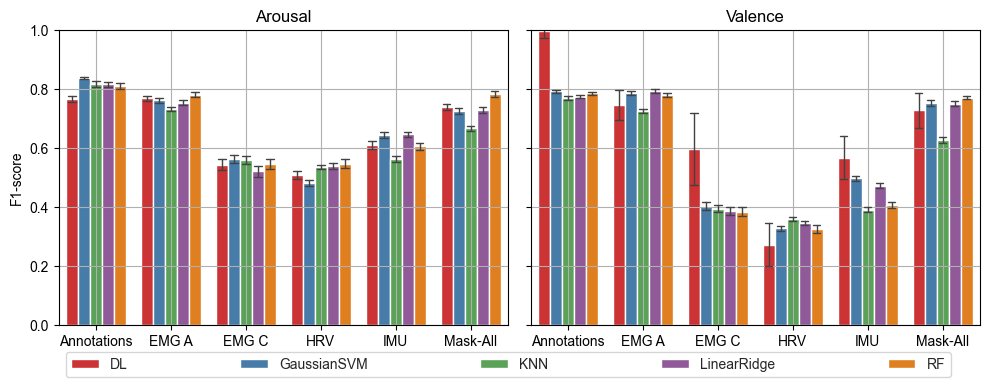

In [43]:
fig,axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)

for i,target in enumerate(df_temp_mean["Target"].unique()):
    ax = axes[i]
    data_plot = df_temp_mean[df_temp_mean["Target"]==target]

    # Plot
    sns.set_style("whitegrid")
    sns.barplot(ax = ax, data = data_plot,
                    x="Data Modality", y="F1-score", hue="Classifier",
                    errorbar="sd", errwidth=1, capsize=0.1, palette="Set1")
    
    ax.set(title=target,
           ylabel=None,
           xlabel=None,
           ylim=[0,1])
    ax.grid(True)
    ax.legend().set_visible(False)
    if(i==0):
        ax.set(ylabel="F1-score")
        ax.legend().set_visible(True)
        # plt.legend(bbox_to_anchor=(0, -0.2, 5, 5), loc="lower right")
        ax.legend(bbox_to_anchor=(0, -0.2, 2, 0.4), loc="lower left", mode="expand", ncol=5)

plt.tight_layout()
save_path_plot = gen_path_plot(f"results-classif-perModality-perClassifier-valence-arousal")
plt.savefig(save_path_plot)

Best combination data modality/classifier per participant

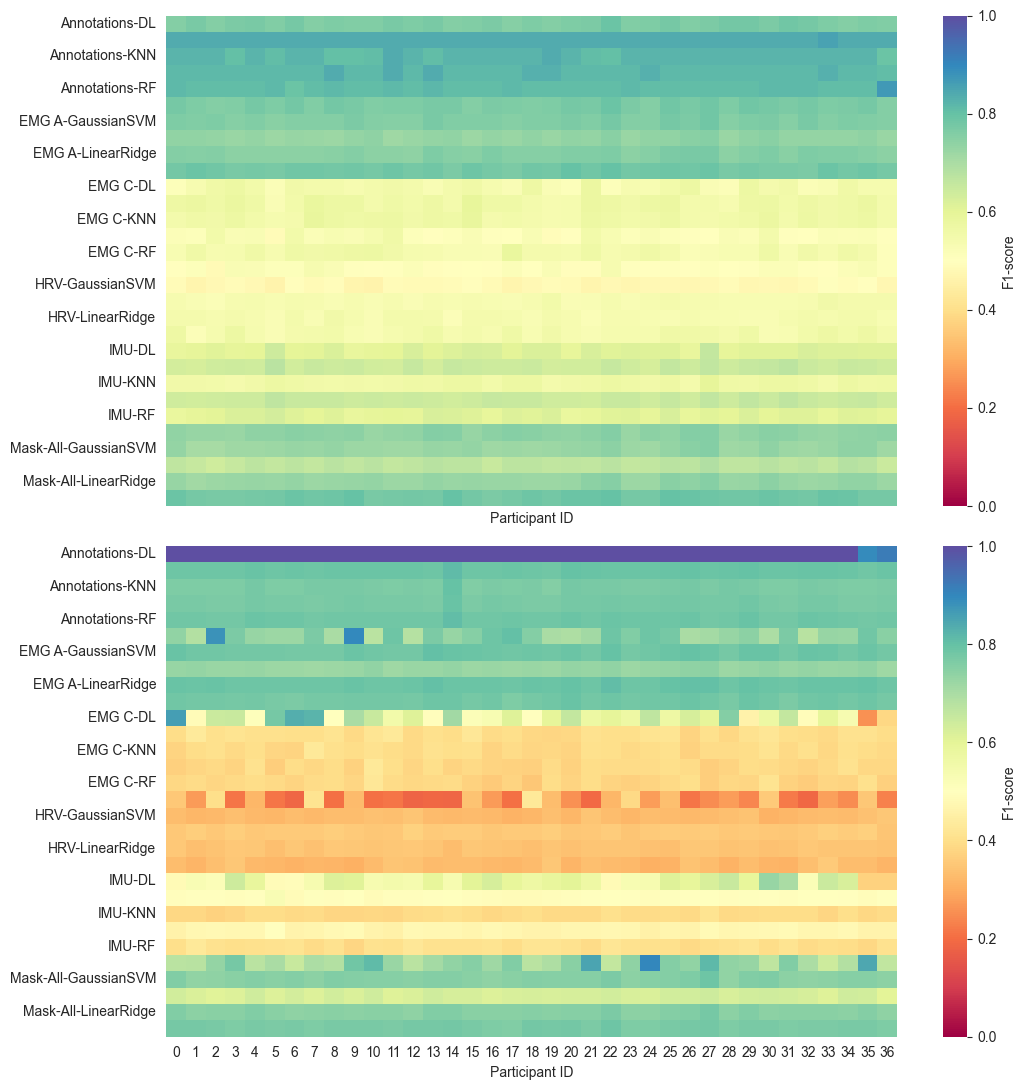

In [44]:
# F1-score per subject
fig,axes = plt.subplots(2, 1, figsize=(11,11),sharex=True)

for i,target in enumerate(df_temp_mean["Target"].unique()):
    ax = axes[i]
    data_plot = df_temp_mean[df_temp_mean["Target"]==target]

    df_heatmap = data_plot.pivot(index=["Data Modality","Classifier"], columns="Subject", values="F1-score")
    sns.heatmap(df_heatmap, ax=ax, cmap="Spectral", vmin=0, vmax=1, 
                cbar_kws={"label": "F1-score"})
    
    ax.set(xlabel='Participant ID',
           ylabel=None)


plt.tight_layout()
save_path_plot = gen_path_plot(f"results-classif-heatmap-perSubjectID-valence-arousal")
plt.savefig(save_path_plot, bbox_inches='tight', pad_inches = 0)

C:\Users\luva3178\AppData\Local\Temp\ipykernel_8144\178709538.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


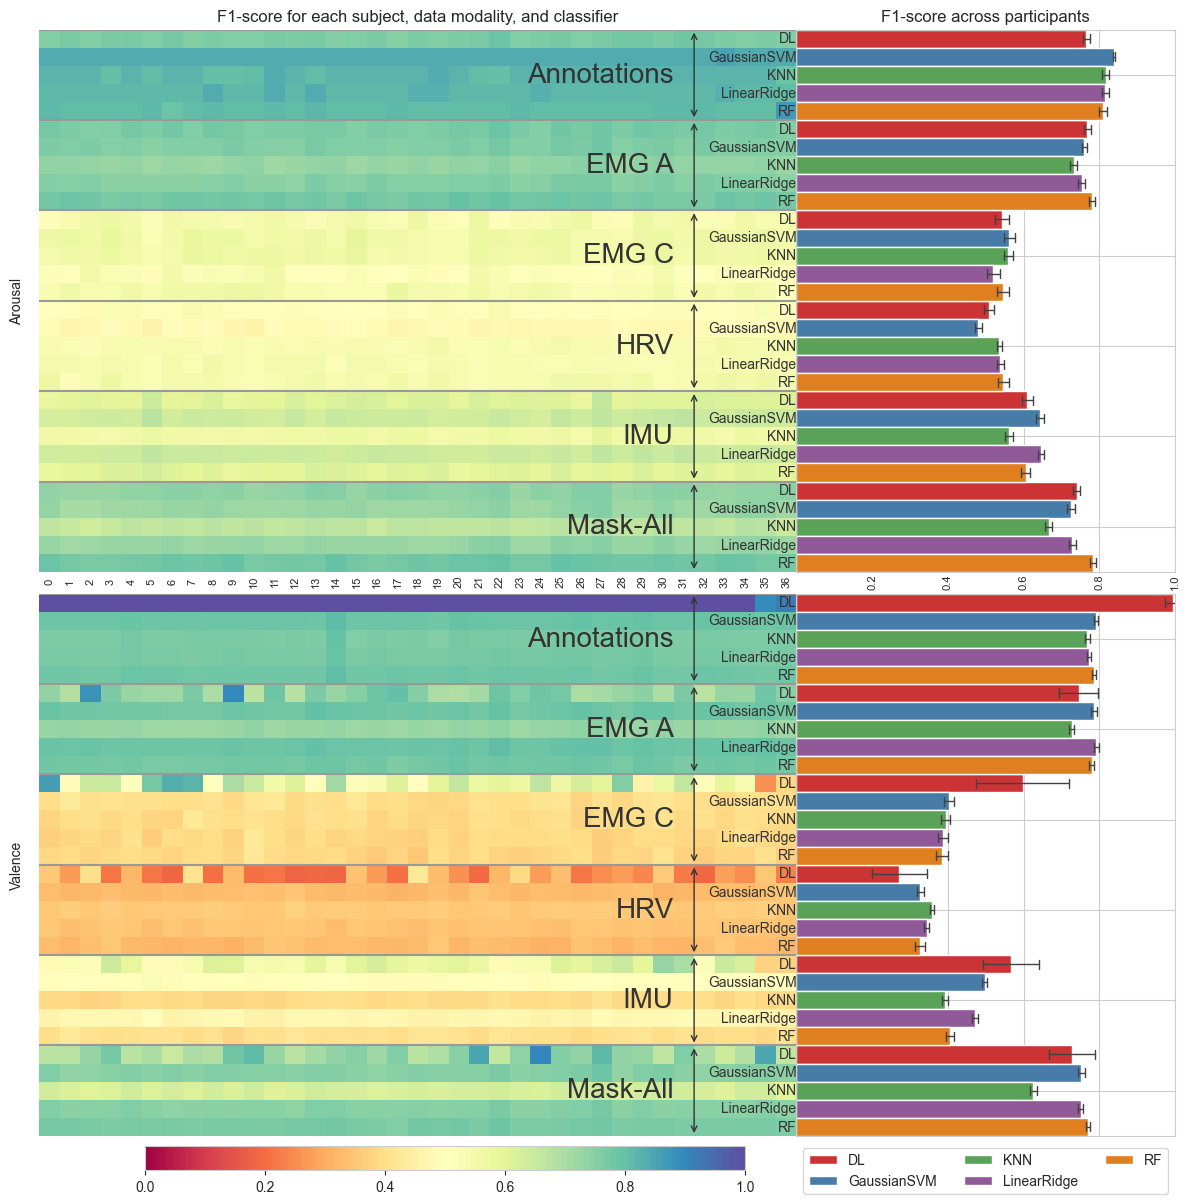

In [60]:
fig,axes = plt.subplots(2, 2, figsize=(12,12), gridspec_kw={'width_ratios': [2, 1]})
sns.set_style("whitegrid")

for i,target in enumerate(df_temp_mean["Target"].unique()):
    data_plot = df_temp_mean[df_temp_mean["Target"]==target]

    ###### Heatmap
    ax = axes[i,0]
    df_heatmap = data_plot.pivot(index=["Data Modality","Classifier"], columns="Subject", values="F1-score")
    df_heatmap.sort_index(ascending=True, inplace=True)
    sns.heatmap(df_heatmap, ax=ax, cmap="Spectral", vmin=0, vmax=1,
                    cbar=False,
                    cbar_kws={"label":"F1-score", "location":"bottom"})

    # Add manual labels for classifier
    custom_n_labels = df_heatmap.shape[0]
    # custom_labels = [f"{val[0]} | {val[1]}" for val in df_heatmap.index.tolist()] # Display Modality | Classifier
    custom_labels_modality = df_heatmap.reset_index()["Data Modality"].unique() # Display Modality Only
    custom_labels_classifier = [f"{val[1]}" for val in df_heatmap.index.tolist()] # Display Classifier Only

    # Add manual labels for classifier
    color_labels = '0.2'
    for tidx in range(custom_n_labels):
        ax.annotate(custom_labels_classifier[tidx], xy=(df_heatmap.shape[1],0.5+tidx),
                    verticalalignment="center", horizontalalignment="right",
                    color=color_labels)
    # Add big labels per data modality
    for tidx in range(custom_labels_modality.size):
        ax.annotate(custom_labels_modality[tidx], xy=(31, (tidx*5) + 2.5),
                    size=20, verticalalignment="center", horizontalalignment="right",
                    color=color_labels)
        ax.annotate("", xy=(32,tidx*5), xytext=(32,(tidx+1)*5), 
                    arrowprops=dict(
                        arrowstyle="<->",
                        color=color_labels
                        ))
        ax.hlines(y=[tidx*5], xmin=0, xmax=df_heatmap.shape[1], color="0.6")

    ax.grid(True)
    ax.set(ylabel=target,
           xlabel=None)
    ax.set_yticklabels([])
    ax.set_xticks(ax.get_xticks(), ha="center", va="center")
    ax.tick_params(axis='x', labelrotation=90, pad=3, labelsize=8)

    if(i==0): #Arousal
        ax.set(title="F1-score for each subject, data modality, and classifier")
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_verticalalignment('center')
    if(i==1): #Valence
        ax.set_xticklabels([])
        # Color bar
        norm = plt.Normalize(vmin=0, vmax=1)
        sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)
        sm.set_array([])

        cax = fig.add_axes([ax.get_position().x0, ax.get_position().y0 - 0.09, 0.5, 0.02])
        fig.colorbar(sm, cax=cax, orientation='horizontal')

    #### Plot Barplot
    ax = axes[i,1]

    sns.barplot(ax = ax, data = data_plot,orient='h',
                    x="F1-score",
                    y="Data Modality",
                    hue="Classifier",
                    width=1.0,
                    errorbar="sd", errwidth=1, capsize=0.1, palette="Set1")
    ax.grid(True)
    ax.set(xlabel=None, ylabel=None, xlim=[0,1])
    ax.set_yticklabels([])
    ax.set_xticks([0.2, 0.4, 0.6, 0.8, 1], ha="center", va="center")
    ax.tick_params(axis='x', labelrotation=90, pad=-2, labelsize=8)
    ax.legend().set_visible(False)

    if(i==0): #FIRST ROW: AROUSAL
        ax.set(title="F1-score across participants")
    
    if(i==1):
        ax.set_xticklabels([])
        ax.legend().set_visible(True)
        ax.legend(bbox_to_anchor=(0, -0.12, 1, 0.4), loc="lower left", mode="expand", ncol=3)

plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0.04)
save_path_plot = gen_path_plot(f"results-classif-heatmap-boxplot-COMPLETE")
plt.savefig(save_path_plot)


In [46]:
print(">> FINISHED WITHOUT ERRORS!!")

>> FINISHED WITHOUT ERRORS!!
